In [35]:
# To view Model Summary
!pip install -q torchinfo

In [36]:
import torch
from torchvision import datasets, transforms

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

all_pixels = torch.cat([img.view(-1) for img, _ in dataset])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.2860, Std: 0.3530


In [37]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

In [38]:
# set seed for reproducibility
def set_seeds():
    SEED_VALUE = 42
    
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()

<h1>Prepare the DataLoader</h1>

In [39]:
# Step 1: Download the training set without normalization
raw_transform = transforms.Compose([transforms.ToTensor()])
train_set_raw = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=raw_transform)

# Step 2: Compute mean and std from the training set
all_pixels = torch.cat([img.view(-1) for img, _ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Compute Mean: {mean:.4f}, Compute std: {std:.4f}")

# Step 3: Define the new transform using the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Step 4: Reload datasets with proper normalization
train_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST(root="F_MNIST_data", download=True, train=False, transform=transform)

print("Total Train Images: ", len(train_set))
print("Total Val Images: ", len(val_set))

100.0%
100.0%
100.0%
100.0%


Compute Mean: 0.2860, Compute std: 0.3530
Total Train Images:  60000
Total Val Images:  10000


In [40]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=64)

In [41]:
class_mapping = {i: class_name for i, class_name in enumerate([
    "T-shirt/top",
    "Touser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Angkle boot"
])}

<h1>2. Dataset Visualization</h1>

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


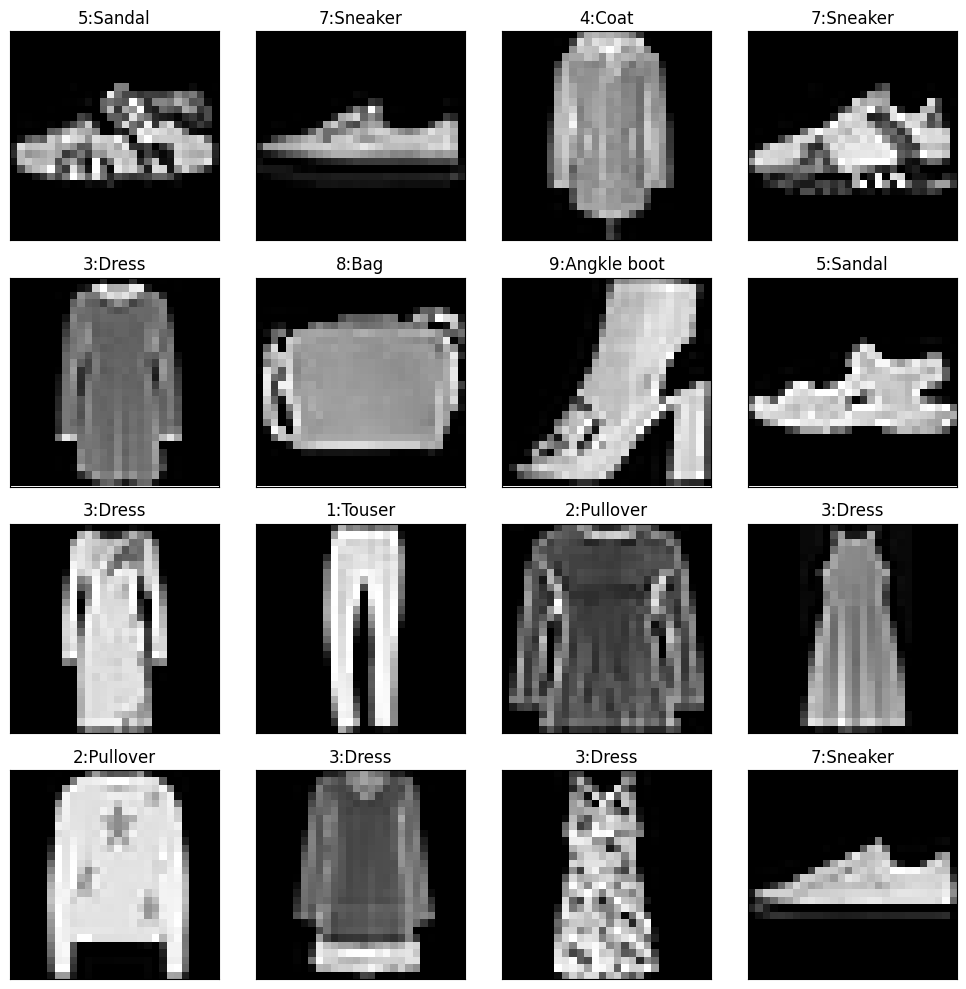

In [42]:
def visualize_images(train_loader, num_images=20):
    fig = plt.figure(figsize=(10, 10))
    
    # Iterate over the first batch
    images, labels = next(iter(train_loader))
    
    # To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))
    
    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        print(np.squeeze(image).size())
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")
    
    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

<h1>3. Model Architecture</h1>

In [43]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc_0 = nn.Linear(784, 512)
        self.bn_0 = nn.BatchNorm1d(512)
        self.fc_1 = nn.Linear(512, 256)
        self.bn_1 = nn.BatchNorm1d(256)
        self.fc_2 = nn.Linear(256, 128)
        self.bn_2 = nn.BatchNorm1d(128)
        self.fc_3 = nn.Linear(128, 64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.fc_4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1) # convert matrix 28x28 -> 1x784
        
        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn_0(self.fc_0(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout(x)
        
        # Output layer
        x = F.relu(self.bn_3(self.fc_3(x)))
        x = F.log_softmax(self.fc_4(x), dim=1)
        
        return x

mlp_model = MLP(num_classes=10)

In [44]:
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc_0)                          [1, 512]                  401,920
├─BatchNorm1d (bn_0)                     [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc_1)                          [1, 256]                  131,328
├─BatchNorm1d (bn_1)                     [1, 256]                  512
├─Linear (fc_2)                          [1, 128]                  32,896
├─BatchNorm1d (bn_2)                     [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc_3)                          [1, 64]                   8,256
├─BatchNorm1d (bn_3)                     [1, 64]                   128
├─Linear (fc_4)                          [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

<h3>Training Configuration</h3>

In [45]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

<h3>Model Training</h3>

In [ ]:
def train(model, train_loader, criterion, optimizer, DEVICE):
    # set model to training mode
    model.train()
    
    # Move model to the specified device (GPU/CUDA)
    model.to(DEVICE)
    
    # Initialize variables to track loss and accuracy
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Iterate over the training dataset
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Reset gradients to prevent accumulation from previous batches
        optimizer.zero_grad()
        
        # Get predictions
        outputs = model(images)
        
        # Compute the loss between prediction and ground truth labels
        loss = criterion(outputs, labels)
        
        # Backpropagation: Compute gradients
        loss.backward()
        
        # Update model weights using the optimizer
        optimizer.step()
        
        running_loss += loss.item()
        
        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs.data, dim=1)
        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy
    

In [ ]:
def validation(model, val_loader, criterion, DEVICE):
    # Set the model to evaluation mode (disables dropout; batch norm behave differently)
    model.eval()
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions/total_samples
    return avg_loss, accuracy

In [48]:
def main(model, train_loader, val_loader, epochs=5, DEVICE="cuda"):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    

Epoch 01/40 - Train Loss: 0.5621, Train Accuracy: 79.80% - Val Loss: 0.4314, Val Accuracy: 84.57%
Epoch 02/40 - Train Loss: 0.4324, Train Accuracy: 84.63% - Val Loss: 0.3881, Val Accuracy: 85.69%
Epoch 03/40 - Train Loss: 0.3999, Train Accuracy: 85.67% - Val Loss: 0.3703, Val Accuracy: 86.47%
Epoch 04/40 - Train Loss: 0.3738, Train Accuracy: 86.45% - Val Loss: 0.3624, Val Accuracy: 87.06%
Epoch 05/40 - Train Loss: 0.3559, Train Accuracy: 87.09% - Val Loss: 0.3485, Val Accuracy: 87.11%
Epoch 06/40 - Train Loss: 0.3371, Train Accuracy: 87.78% - Val Loss: 0.3385, Val Accuracy: 87.48%
Epoch 07/40 - Train Loss: 0.3238, Train Accuracy: 88.22% - Val Loss: 0.3466, Val Accuracy: 87.19%
Epoch 08/40 - Train Loss: 0.3100, Train Accuracy: 88.63% - Val Loss: 0.3226, Val Accuracy: 88.38%
Epoch 09/40 - Train Loss: 0.3023, Train Accuracy: 89.03% - Val Loss: 0.3189, Val Accuracy: 88.14%
Epoch 10/40 - Train Loss: 0.2958, Train Accuracy: 89.24% - Val Loss: 0.3247, Val Accuracy: 87.91%
Epoch 11/40 - Train 

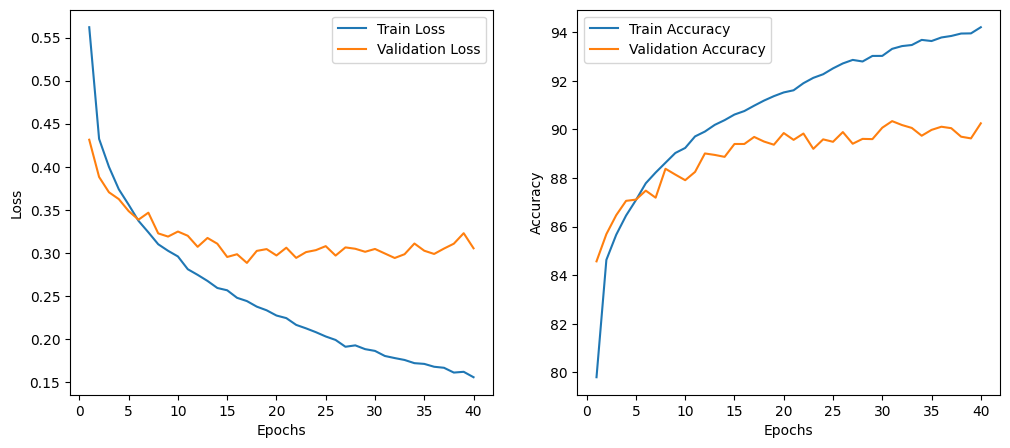

In [49]:
main(mlp_model, train_loader, val_loader, epochs=num_epochs, DEVICE=DEVICE)

<h1>5. Inference Result</h1>

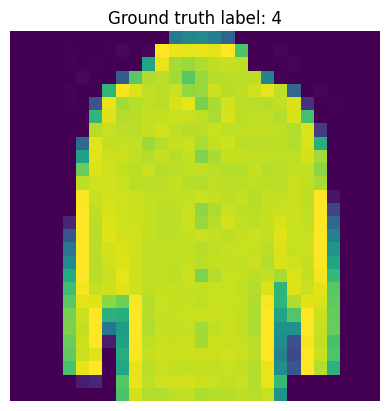

In [50]:
images, gt_labels = next(iter(val_loader))
rand_idx = random.choice(range(len(images)))
plt.imshow(images[rand_idx].squeeze())
plt.title("Ground truth label: " + str(int(gt_labels[rand_idx])), fontsize=12)
plt.axis("off")
plt.show()

In [51]:
bold = f"\033[1m"
reset = f"\033[0m"
mlp_model.eval()
with torch.no_grad():
    batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()
prob_score_text_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_text_image.argmax()

print("Predictions for each class on the test image:\n")
for idx, cls_prob in enumerate(prob_score_text_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")
        

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Touser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.043
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.953
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.004
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Angkle boot, Probability: 0.000


<h1>Confussion Matrix</h1>

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [53]:
def prediction_batch(model, batch_inputs):
    model.eval()
    batch_outputs = model(batch_inputs)
    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1)
    batch_cls_ids = batch_probs.argmax(dim=1)
    return batch_cls_ids.cpu()

In [54]:
val_target_labels = []
val_predicted_labels = []
for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)
    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)
    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()
    

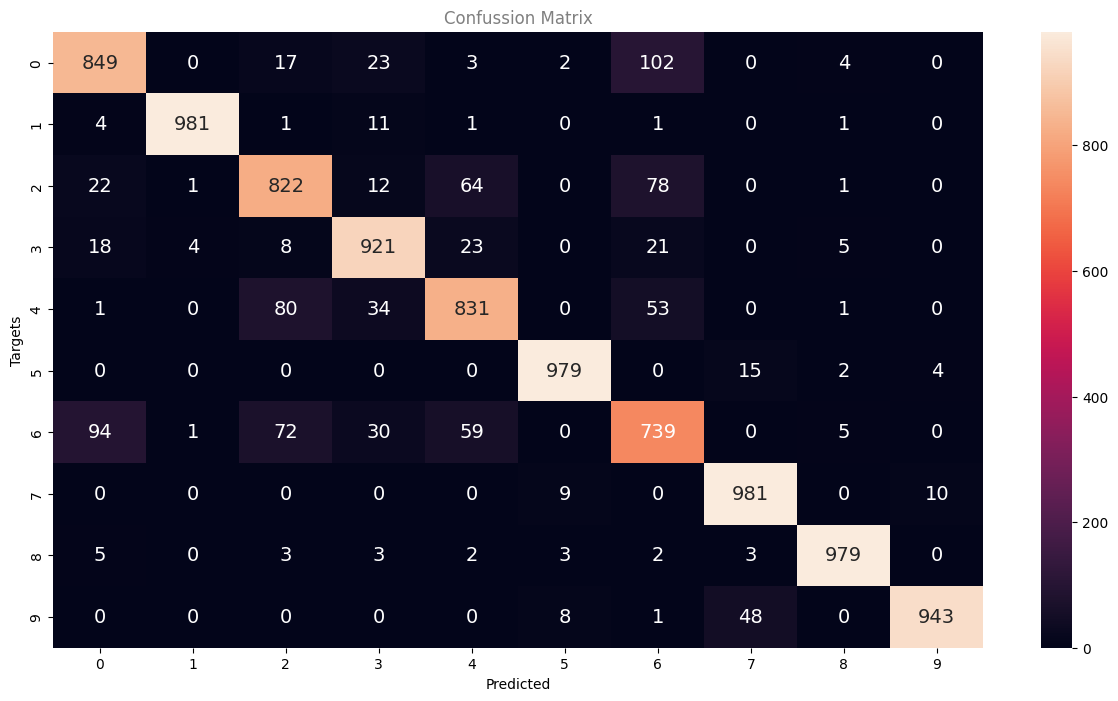

In [55]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)
plt.figure(figsize=[15, 8])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confussion Matrix", color="gray")
plt.show()